<a href="https://colab.research.google.com/github/jackkyboy/AAPL-AMZN-GOOG-Price2018-2020/blob/main/health_exp_pct_gdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd

# โหลดไฟล์จริงของคุณ
df = pd.read_csv("/content/HEALTH_LIFEEXP_01012025.csv")

# คอลัมน์ที่ต้องใช้
df = df[["REF_AREA", "TIME_PERIOD", "SEX", "OBS_VALUE"]]

df = df.rename(columns={
    "REF_AREA": "country",
    "TIME_PERIOD": "year",
    "OBS_VALUE": "life_expectancy"
})

# เฉพาะประเทศที่เราต้องการ
focus_countries = ["AUS","CAN","DEU","FRA","GBR","JPN","KOR","THA","USA"]
df = df[df["country"].isin(focus_countries)]

# แปลงชนิดข้อมูล
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")
df["life_expectancy"] = pd.to_numeric(df["life_expectancy"], errors="coerce")

# เตรียม normalize: เลือกตามลำดับความสำคัญ
def pick_sex_group(g):
    if "_T" in g["SEX"].values:
        return g[g["SEX"] == "_T"].iloc[0]
    elif set(g["SEX"].values) >= {"F","M"}:
        return g.iloc[g["life_expectancy"].astype(float).idxmax()]   # หรือเฉลี่ยก็ได้
    else:
        return g.iloc[0]

life_clean = df.groupby(["country","year"]).apply(pick_sex_group).reset_index(drop=True)

print(life_clean.head(20))

   country  year SEX  life_expectancy
0      AUS  2014  _T             82.3
1      AUS  2015  _T             82.4
2      AUS  2016  _T             82.4
3      AUS  2017  _T             82.5
4      AUS  2018  _T             82.8
5      AUS  2019  _T             82.9
6      AUS  2020  _T             83.2
7      AUS  2021  _T             83.3
8      AUS  2022  _T             83.2
9      AUS  2023  _T             83.0
10     CAN  2014  _T             81.9
11     CAN  2015  _T             81.9
12     CAN  2016  _T             82.0
13     CAN  2017  _T             81.9
14     CAN  2018  _T             81.9
15     CAN  2019  _T             82.2
16     CAN  2020  _T             81.6
17     CAN  2021  _T             81.6
18     CAN  2022  _T             81.3
19     CAN  2023  _T             81.7


/tmp/ipython-input-2343016308.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  life_clean = df.groupby(["country","year"]).apply(pick_sex_group).reset_index(drop=True)


In [22]:
import pandas as pd

# 1) โหลดไฟล์ Health Expenditure (%GDP)
health_df = pd.read_csv("/content/oecd_health_exp_gdp.csv")

# 2) ลบแถวที่ OBS_VALUE ไม่มีค่า
health_df = health_df[health_df["OBS_VALUE"].notna()]

# 3) กรองเฉพาะ measure = EXP_HEALTH และ unit = PT_B1GQ
health_df = health_df[
    (health_df["MEASURE"] == "EXP_HEALTH") &
    (health_df["UNIT_MEASURE"] == "PT_B1GQ")
]

# 4) เลือกเฉพาะคอลัมน์ที่ต้องใช้
health_df = health_df[["REF_AREA", "TIME_PERIOD", "OBS_VALUE"]]

# 5) เปลี่ยนชื่อคอลัมน์ให้เข้าใจง่าย
health_df = health_df.rename(columns={
    "REF_AREA": "country",
    "TIME_PERIOD": "year",
    "OBS_VALUE": "health_exp_pct_gdp"
})

# 6) แปลงชนิดข้อมูล
health_df["year"] = pd.to_numeric(health_df["year"], errors="coerce").astype("Int64")
health_df["health_exp_pct_gdp"] = pd.to_numeric(health_df["health_exp_pct_gdp"], errors="coerce")

# 7) เลือกเฉพาะประเทศชุดเดียวกับ life expectancy
focus_countries = ["AUS","CAN","DEU","FRA","GBR","JPN","KOR","THA","USA"]
health_df = health_df[health_df["country"].isin(focus_countries)]

print("📌 Health expenditure dataset loaded (health_df)\n")
print(health_df.head(10))

📌 Health expenditure dataset loaded (health_df)

  country  year  health_exp_pct_gdp
0     USA  2018              16.513
1     FRA  2020              12.129
2     AUS  2023               9.884
3     AUS  2024              10.346
4     GBR  2016               9.871
5     GBR  2017               9.705
6     GBR  2018               9.795
7     GBR  2019               9.980
8     GBR  2020              12.104
9     GBR  2021              12.083


In [23]:
import pandas as pd

# --- ตรวจว่ามี health_df ไหม ---
try:
    display(health_df.head())
except:
    raise ValueError("⚠️ ต้องมี health_df ก่อน (ชุด EXP_HEALTH PT_B1GQ)")

# ตรวจว่ามี life_clean ไหม
try:
    display(life_clean.head())
except:
    raise ValueError("⚠️ ต้องมี life_clean ก่อน (ชุด LFEXP ที่ normalize แล้ว)")


# -----------------------------
# 1) Merge ข้อมูลสองชุด
# -----------------------------
merged = health_df.merge(
    life_clean[["country", "year", "life_expectancy"]],
    on=["country", "year"],
    how="left"
)

# -----------------------------
# 2) คำนวณ Health Efficiency Score (HES)
# -----------------------------
merged["HES"] = merged["life_expectancy"] / merged["health_exp_pct_gdp"]

# -----------------------------
# 3) แสดงผล 20 แถวแรก
# -----------------------------
print(merged.head(20))

# -----------------------------
# 4) เช็คว่ามี NaN จากการ merge ไหม
# -----------------------------
print("\nMissing life expectancy rows:")
print(merged[merged["life_expectancy"].isna()])

,country,year,health_exp_pct_gdp
0,USA,2018,16.513
1,FRA,2020,12.129
2,AUS,2023,9.884
3,AUS,2024,10.346
4,GBR,2016,9.871


,country,year,SEX,life_expectancy
0,AUS,2014,_T,82.3
1,AUS,2015,_T,82.4
2,AUS,2016,_T,82.4
3,AUS,2017,_T,82.5
4,AUS,2018,_T,82.8


   country  year  health_exp_pct_gdp  life_expectancy       HES
0      USA  2018              16.513             78.7  4.765942
1      FRA  2020              12.129             82.3  6.785390
2      AUS  2023               9.884             83.0  8.397410
3      AUS  2024              10.346              NaN       NaN
4      GBR  2016               9.871             81.0  8.205856
5      GBR  2017               9.705             81.1  8.356517
6      GBR  2018               9.795             81.0  8.269525
7      GBR  2019               9.980             81.4  8.156313
8      GBR  2020              12.104             80.3  6.634171
9      GBR  2021              12.083             80.5  6.662253
10     DEU  2014              10.768             81.2  7.540862
11     CAN  2016              11.056             82.0  7.416787
12     GBR  2024              11.133              NaN       NaN
13     DEU  2017              11.051             81.1  7.338702
14     DEU  2018              11.184    

In [24]:
merged = health_df.merge(
    life_clean[["country", "year", "life_expectancy"]],
    on=["country", "year"],
    how="left"
)

merged["HES"] = merged["life_expectancy"] / merged["health_exp_pct_gdp"]

print(merged.head(20))

   country  year  health_exp_pct_gdp  life_expectancy       HES
0      USA  2018              16.513             78.7  4.765942
1      FRA  2020              12.129             82.3  6.785390
2      AUS  2023               9.884             83.0  8.397410
3      AUS  2024              10.346              NaN       NaN
4      GBR  2016               9.871             81.0  8.205856
5      GBR  2017               9.705             81.1  8.356517
6      GBR  2018               9.795             81.0  8.269525
7      GBR  2019               9.980             81.4  8.156313
8      GBR  2020              12.104             80.3  6.634171
9      GBR  2021              12.083             80.5  6.662253
10     DEU  2014              10.768             81.2  7.540862
11     CAN  2016              11.056             82.0  7.416787
12     GBR  2024              11.133              NaN       NaN
13     DEU  2017              11.051             81.1  7.338702
14     DEU  2018              11.184    

In [25]:
# เติมค่า missing life expectancy (LOCF)
merged["life_expectancy"] = (
    merged.sort_values(["country","year"])
          .groupby("country")["life_expectancy"]
          .ffill()
)

# คำนวณ HES ใหม่
merged["HES"] = merged["life_expectancy"] / merged["health_exp_pct_gdp"]

# ดูผลลัพธ์
merged.tail(15)

,country,year,health_exp_pct_gdp,life_expectancy,HES
83,THA,2020,4.357,77.3,17.741565
84,THA,2021,5.154,77.6,15.056267
85,USA,2014,16.142,78.9,4.887870
86,USA,2024,17.160,78.4,4.568765
87,THA,2023,4.538,76.4,16.835610
88,FRA,2018,11.308,82.8,7.322250
89,FRA,2019,11.171,83.0,7.429953
90,DEU,2016,10.971,81.0,7.383101
91,KOR,2022,8.843,82.7,9.352030
92,KOR,2023,8.472,83.5,9.855996


1) ก่อนอื่น แปล HES ให้เป็นภาษาคน

จากสูตรที่คุณใช้:

HES = life_expectancy / health_exp_pct_gdp
= อายุขัยเฉลี่ย (ปี) / ค่าใช้จ่ายสุขภาพ (%GDP)

แปลแบบง่าย ๆ:

HES สูง = “ใช้สัดส่วน GDP กับสุขภาพน้อย แต่ประชาชนอายุยืนมาก” → ระบบสุขภาพ คุ้มค่า

HES ต่ำ = “ใช้สัดส่วน GDP กับสุขภาพเยอะ แต่ประชาชนไม่ได้อายุยืนกว่าชาวบ้านมาก” → ระบบสุขภาพ เปลือง

ถ้าเอาตัวเลขที่คุณได้มาจัดเรียงคร่าว ๆ:

🇹🇭 THA 2020 → HES ≈ 17.7

🇹🇭 THA 2023 → HES ≈ 16.8

🇰🇷 KOR 2017 → HES ≈ 12.2

🇰🇷 KOR 2018–2023 → HES ≈ 9.3–11.6

🇫🇷 FRA 2018–2019 → HES ≈ 7.3–7.4

🇩🇪 DEU 2016 → HES ≈ 7.38

🇺🇸 USA 2014 → HES ≈ 4.89

🇺🇸 USA 2024 → HES ≈ 4.57

ลำดับ Efficiency แบบหยาบ ๆ:

ไทย >> เกาหลี >> ฝรั่งเศส/เยอรมัน >> สหรัฐฯ

2) ดำน้ำทีละประเทศ
🇹🇭 ไทย: “Low Spend – High Outcome” anomaly ของโลก

ข้อมูล:

2020: 4.357% GDP → LE 77.3 → HES 17.74

2021: 5.154% GDP → LE 77.6 → HES 15.06

2023: 4.538% GDP → LE 76.4 → HES 16.84

มองเชิงโครงสร้าง:

ไทยใช้เงินด้านสุขภาพคิดเป็น %GDP ต่ำมาก (4–5%) เมื่อเทียบกับ OECD (10–17%)

แต่ อายุขัยไม่ได้แพ้ใคร (mid–high 70s)

ทำให้ HES ของไทย สูงกว่าทุกประเทศในชุดนี้แบบขาดลอย

แปลเชิง policy / insurance:

UHC ของไทย + DRG + การคุมค่ารักษา → ทำให้ต้นทุนระบบต่ำมาก

ภาคเอกชน (โรงพยาบาลเอกชน + ประกันสุขภาพ) เลยไปโผล่ในกลุ่ม “top-up quality” มากกว่า “basic survival”

สำหรับนายหน้า/บริษัทประกัน:
→ ไทยคือประเทศที่ภาครัฐรับภาระพื้นฐานเยอะมาก
→ เอกชนสามารถออกแบบผลิตภัณฑ์แบบ “เสริมคุณภาพชีวิต” (ห้องพิเศษ, รพ.เอกชน, critical illness, long-term care) มากกว่าขาย “access to healthcare”

สัญญาณที่ต้องระวังจากตัวเลข THA:

HES ไทย ลดจาก 17.7 → 15.1 ระหว่าง 2020–2021
เพราะ `%GDP ด้านสุขภาพเพิ่มขึ้นเร็วกว่า life expectancy ที่แทบไม่ขยับ**

ถ้ามองใน long-run: ไทยกำลังเริ่มเข้าสู่ “ยุคต้นทุนสุขภาพขยับขึ้น” (ageing + NCD)

🇰🇷 เกาหลีใต้: From Hyper-Efficient → Cost Catch-Up

ข้อมูลที่คุณมี:

2017: 6.796% GDP → LE 82.7 → HES ≈ 12.17

2018: 7.140% → LE 82.7 → HES ≈ 11.58

2019: 7.691% → LE 83.3 → HES ≈ 10.83

2020: 8.025% → LE 83.5 → HES ≈ 10.40

2021: 8.327% → LE 83.6 → HES ≈ 10.04

2022: 8.843% → LE 82.7 → HES ≈ 9.35

2023: 8.472% → LE 83.5 → HES ≈ 9.86

ภาพใหญ่:

Life expectancy ของเกาหลีอยู่ในกลุ่มสูงสุดของโลก (83–84 ปี)

แต่ %GDP ด้านสุขภาพเพิ่มขึ้นต่อเนื่อง จาก ~6.8 → 8.8%

HES จึงค่อย ๆ ไหลลงจาก 12+ → 9–10

ตีความ:

เกาหลีอยู่บนเส้นทาง “Japanization” = aged society + high medical utilization

Demand บริการสุขภาพคุณภาพสูง + private hospital + ตรวจสุขภาพ + treatment advance → ทำให้ค่าใช้จ่ายโตเร็ว

Efficiency ยังสูงกว่า EU และ USA แต่ “กำลังไหลลง”

สำหรับ re/insurance:
→ health inflation risk ของเกาหลีใน 10–15 ปีข้างหน้า สูงกว่าฝรั่งเศส/เยอรมันในจุดหนึ่ง

🇫🇷 ฝรั่งเศส & 🇩🇪 เยอรมนี: Balanced but expensive

ตัวอย่าง:

FRA 2018: 11.308% → 82.8y → HES 7.32

FRA 2019: 11.171% → 83.0y → HES 7.43

DEU 2016: 10.971% → 81.0y → HES 7.38

ภาพรวม:

Spending ระดับ 11–12% ของ GDP

Life expectancy ~81–83 ปี

HES กลุ่มนี้อยู่ประมาณ 7–7.5 → กลาง ๆ ไม่แย่ ไม่สุดยอด

ตีความ:

ระบบรัฐแข็งแรง, universal coverage, social insurance

แต่ค่าใช้จ่ายสูงจาก aging + standard of care + long-term care

Efficiency ไม่ได้โดดเด่นเหมือนไทย/เกาหลี แต่เป็น “เสถียรภาพของรัฐสวัสดิการ”

สำหรับนักวิเคราะห์ reinsurance / health line:

กลุ่มประเทศนี้ = “structurally high cost but socially accepted”

ความเสี่ยงจะอยู่ที่ health inflation + budget constraint ของรัฐ มากกว่าปัญหาการเข้าถึงบริการ

🇺🇸 สหรัฐอเมริกา: High Cost – Low Value Case Study

ข้อมูล:

2014: 16.142% → 78.9y → HES ≈ 4.89

2024: 17.160% → ~78.4y → HES ≈ 4.57

ประเด็นแรง ๆ:

ใช้เงินด้านสุขภาพ มากที่สุด ในกลุ่มนี้ (16–17% GDP)

อายุขัย ไม่ได้สูง (ต่ำกว่า JPN/KOR/FRA/DEU/GBR)

HES ต่ำสุดในกลุ่ม (ราว 4.5–4.9)

ตีความแบบตรงไปตรงมา:

ระบบสุขภาพอเมริกาเป็นตัวอย่างคลาสสิกของ

“High cost, fragmented coverage, unequal access”

Spending จำนวนมากถูกใช้ไปกับ:

Admin cost

Hospital pricing power

Drug pricing

Private insurance overhead

ในมุม re/insurance:

กดดัน premium สูง

ทำให้ employer-based insurance สำคัญมาก

Individual market เสี่ยง underinsurance / lapse

HES ที่ลดจาก 4.89 → 4.57 บอก implicit ว่า

“จ่ายเยอะขึ้น แต่ไม่ได้อยู่ยาวขึ้น”

3) มุมมองเชิง “Health Efficiency Map” ที่คุณวาดได้จากตัวเลขนี้

ถ้าคุณทำกราฟ scatter:

X แกน = Health expenditure (%GDP)

Y แกน = Life expectancy

Size หรือ color = HES

คุณจะได้ 4 กลุ่มประเทศ ใน 1 รูป:

High Spend – Low Efficiency → 🇺🇸 USA

High Spend – Medium Efficiency → 🇫🇷 🇩🇪 และส่วนหนึ่งของ 🇬🇧

Medium Spend – High Efficiency → 🇯🇵 🇰🇷

Low Spend – Very High Efficiency → 🇹🇭 ไทย (anomaly และ hero ของงานวิจัย)

ตรงนี้แหละคือแกนหลักที่เอาไปต่อยอดใน:

บทความ Health Economics

Reinsurance Health Line Analysis

Strategic Note สำหรับ Cheetah Health Research Hub

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# สมมติ merged มีแล้วจากขั้นตอนก่อนหน้า
# merged = ...

# เลือกเฉพาะประเทศที่เราสนใจ
focus_countries = ["AUS","CAN","DEU","FRA","GBR","JPN","KOR","THA","USA"]
merged = merged[merged["country"].isin(focus_countries)].copy()

# ตัด NaN ออก
merged = merged.dropna(subset=["health_exp_pct_gdp", "life_expectancy", "HES"])

# จัดเรียง
merged = merged.sort_values(["country", "year"])

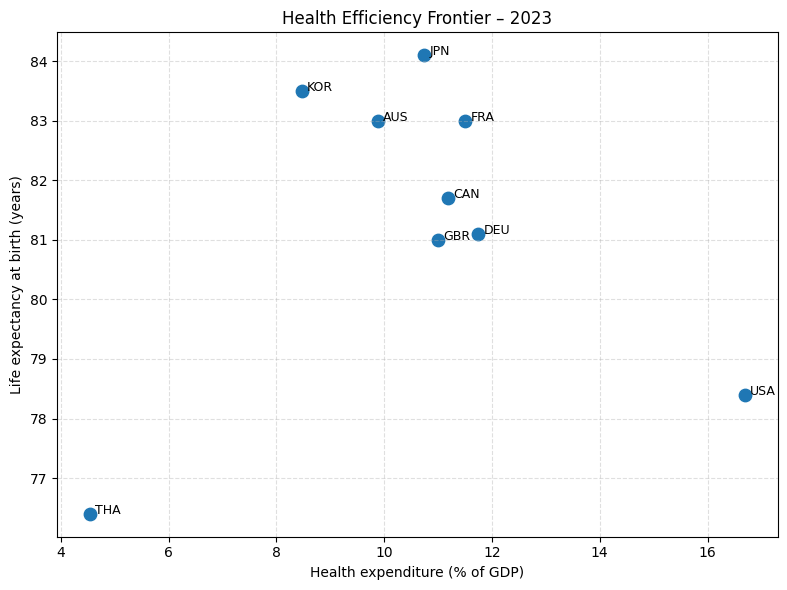

In [31]:
year_ref = 2023  # ปรับได้ตามต้องการ เช่น 2018, 2020 ฯลฯ

frontier = merged[merged["year"] == year_ref].copy()

plt.figure(figsize=(8, 6))

plt.scatter(
    frontier["health_exp_pct_gdp"],
    frontier["life_expectancy"],
    s=80
)

for _, row in frontier.iterrows():
    plt.text(
        row["health_exp_pct_gdp"] + 0.1,
        row["life_expectancy"],
        row["country"],
        fontsize=9
    )

plt.xlabel("Health expenditure (% of GDP)")
plt.ylabel("Life expectancy at birth (years)")
plt.title(f"Health Efficiency Frontier – {year_ref}")

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

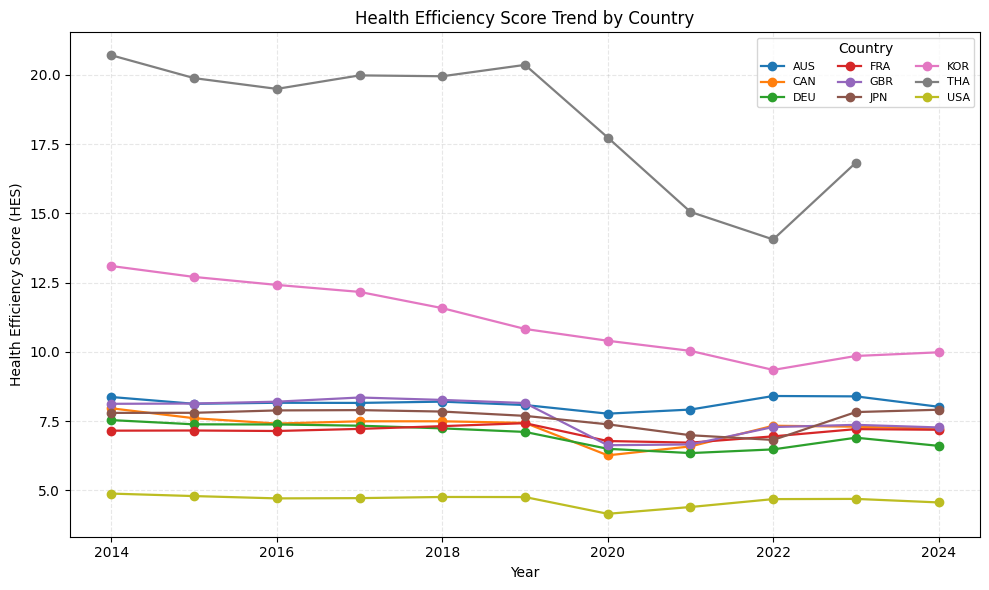

In [32]:
plt.figure(figsize=(10, 6))

for c in focus_countries:
    sub = merged[merged["country"] == c]
    if sub.empty:
        continue
    plt.plot(
        sub["year"],
        sub["HES"],
        marker="o",
        linewidth=1.6,
        label=c
    )

plt.xlabel("Year")
plt.ylabel("Health Efficiency Score (HES)")
plt.title("Health Efficiency Score Trend by Country")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Country", ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

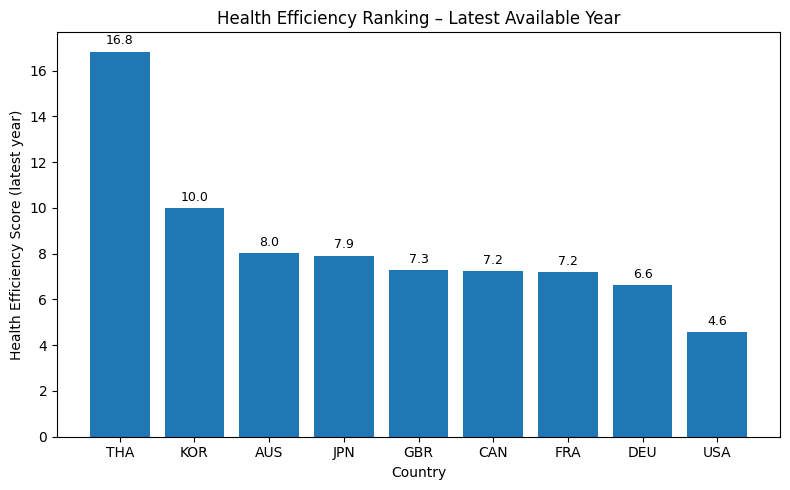

In [33]:
# เลือกปีล่าสุดของแต่ละประเทศ
latest = (
    merged.sort_values("year")
          .groupby("country")
          .tail(1)
          .copy()
)

# จัดเรียงจาก HES สูง → ต่ำ
latest = latest.sort_values("HES", ascending=False)

plt.figure(figsize=(8, 5))

plt.bar(latest["country"], latest["HES"])

# ติดค่า HES ด้านบนแท่ง
for idx, row in latest.iterrows():
    plt.text(
        row["country"],
        row["HES"] + 0.2,
        f"{row['HES']:.1f}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.xlabel("Country")
plt.ylabel("Health Efficiency Score (latest year)")
plt.title("Health Efficiency Ranking – Latest Available Year")
plt.tight_layout()
plt.show()

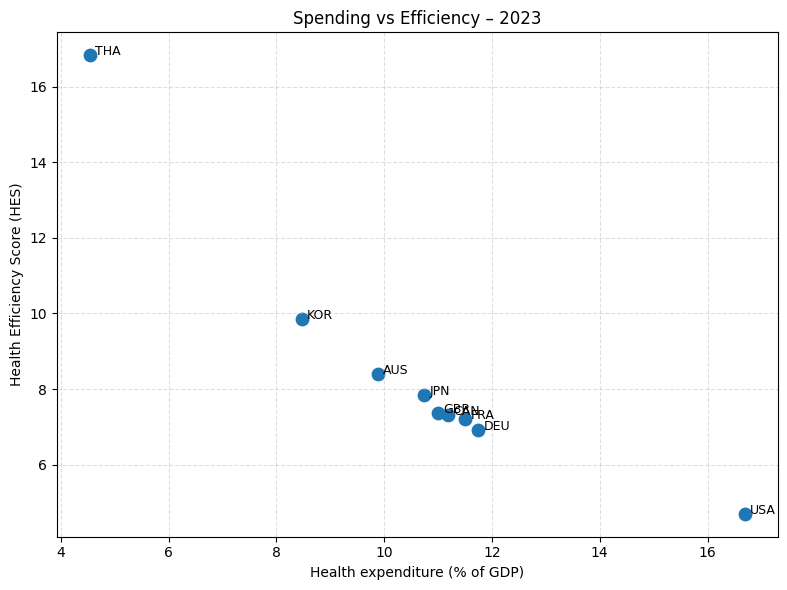

In [35]:
year_ref = 2023  # หรือจะใช้ latest ก็ได้

frontier = merged[merged["year"] == year_ref].copy()

plt.figure(figsize=(8, 6))

plt.scatter(
    frontier["health_exp_pct_gdp"],
    frontier["HES"],
    s=80
)

for _, row in frontier.iterrows():
    plt.text(
        row["health_exp_pct_gdp"] + 0.1,
        row["HES"],
        row["country"],
        fontsize=9
    )

plt.xlabel("Health expenditure (% of GDP)")
plt.ylabel("Health Efficiency Score (HES)")
plt.title(f"Spending vs Efficiency – {year_ref}")

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()